<a href="https://colab.research.google.com/github/MichalRyszardWojcik/hello-world/blob/master/2020_09_04_grawszachy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import os
import numpy as np
! pip install -q -U trax
import trax

In [181]:
import chess
import chess.pgn
import chess.svg

In [182]:
def move2token(move): return 64*move.from_square + move.to_square

def token2move(token):
  from_square = token // 64
  to_square = token % 64
  return chess.Move(from_square,to_square)

def game2tokens(game):
  tokens = []
  line = game.main_line()
  for move in line: tokens.append(move2token(move))
  return tokens

def tokens2board(tokens):
  board = chess.Board()
  for x in tokens:
    from_square = x//64
    to_square = x % 64
    move = chess.Move(from_square,to_square)
    board.push(move)
  return board

In [183]:
# !wget https://chessdiagram.online/games/lichess_db_standard_rated_2014-07.zip

In [184]:
# !unzip lichess_db_standard_rated_2014-07.zip

In [185]:
g_max_ile = 1100*1000
def tokenize(input_pgn_file,output_file):
  ile = 0
  while True:
    game = chess.pgn.read_game(pgn)
    if game == None: return ile
    if len(game.errors) > 0: print(game.errors)
    game = game2tokens(game)
    if len(game) >= 24:
      game = str(game).strip('[]')
      output_file.write(game)
      ile += 1
      if ile % 1000 == 0: print(f'{ile//1000}K games tokenized')
      if ile == g_max_ile:
        output_file.close()
        return ile
      else:
        output_file.write('\n')

In [186]:
#pgn = open('lichess_db_standard_rated_2014-07.pgn','r') # 1,048,440 games
#tokens = open('/content/tokens.txt','w')
#ile = tokenize(pgn,tokens)
#ile

In [187]:
!wget https://chessdiagram.online/games/tokens1000k.zip
!unzip tokens1000k.zip

--2020-09-04 16:39:44--  https://chessdiagram.online/games/tokens1000k.zip
Resolving chessdiagram.online (chessdiagram.online)... 184.154.45.213
Connecting to chessdiagram.online (chessdiagram.online)|184.154.45.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110390368 (105M) [application/zip]
Saving to: ‘tokens1000k.zip.1’

tokens1000k.zip.1   100%[===================>] 105.28M  31.0MB/s    in 4.3s    

2020-09-04 16:39:48 (24.3 MB/s) - ‘tokens1000k.zip.1’ saved [110390368/110390368]

Archive:  tokens1000k.zip
replace tokens1000k.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tokens1000k.txt         


In [188]:
def load_tokenized_games(tokens_file):
  tokenized_games = []
  for line in tokens_file:
    pregame = line.split(", ")
    game = []
    for x in pregame:
      game.append(int(x))
    tokenized_games.append(game)
  return tokenized_games

In [189]:
#tokens = open('/content/tokens.txt','r')
tokens = open('tokens1000k.txt')
tokenized_games = load_tokenized_games(tokens)
ile = len(tokenized_games)

In [190]:
print(ile) #979685 almost a million games

979685


In [191]:
def random_tokenized_game():
  # ile = len(tokenized_games)
  i = np.random.randint(0, ile)
  return tokenized_games[i]

In [192]:
def training_input(batch_size, length):
  while True:
    shape = (batch_size,length)
    games = np.zeros(shape, np.int32)
    for y in range(batch_size):
      game = random_tokenized_game()[0:length-1] # leaves a zero at the end
      for x in range( min( len(game), length ) ):
        games[y,x] = game[x]
    inputs = games
    targets = games
    loss_weights = np.ones(shape, np.int32)
    yield (inputs,targets,loss_weights)

game_length = 60 #40

trax_inputs = trax.data.inputs.Inputs(lambda _: training_input(batch_size=128, length=game_length))

In [193]:
def Chess_transformer_lm(mode='train'):
  return trax.models.TransformerLM(  
          d_model=128,
          d_ff=256,
          n_heads=2,
          n_layers=2, 
          vocab_size= g_vocab_size,
          mode=mode)

In [194]:
g_vocab_size = 64*64

output_dir = os.path.expanduser('~/train_dir/')
!rm -f ~/train_dir/model.pkl.gz  # Remove old model.

# Train tiny model with Trainer.
trainer = trax.supervised.Trainer(
    model=Chess_transformer_lm,
    loss_fn=trax.layers.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adafactor,  # Change optimizer params here.
    lr_schedule=trax.lr.warmup_and_rsqrt_decay(400, 0.01),  # Change lr schedule here.
    inputs=trax_inputs,
    output_dir=output_dir)

n_epochs = 10
train_steps = 500
eval_steps = 2
for _ in range(n_epochs):
  trainer.train_epoch(train_steps, eval_steps)



Step    500: Ran 500 train steps in 29.31 secs
Step    500: Evaluation
Step    500: train                   accuracy |  0.24570315
Step    500: train                       loss |  4.20872879
Step    500: train         neg_log_perplexity | -4.20872879
Step    500: train          sequence_accuracy |  0.00000000
Step    500: train weights_per_batch_per_core |  7680.00000000
Step    500: eval                    accuracy |  0.26087242
Step    500: eval                        loss |  4.12316608
Step    500: eval          neg_log_perplexity | -4.12316608
Step    500: eval           sequence_accuracy |  0.00000000
Step    500: eval  weights_per_batch_per_core |  7680.00000000
Step    500: Finished evaluation

Step   1000: Ran 500 train steps in 12.23 secs
Step   1000: Evaluation
Step   1000: train                   accuracy |  0.30423176
Step   1000: train                       loss |  3.51331115
Step   1000: train         neg_log_perplexity | -3.51331115
Step   1000: train          sequence_

In [195]:
def output(input):
  predict_model = Chess_transformer_lm(mode='predict')
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(os.path.join(output_dir, "model.pkl.gz"),weights_only=True, input_signature=predict_signature)
  return trax.supervised.decoding.autoregressive_sample(predict_model, input, temperature=0.0, max_length=game_length, eos_id = 0)

In [196]:
def fullgame(firstmoves):
  for i in range(len(firstmoves)):
    uci = firstmoves[i]
    move = chess.Move.from_uci(uci)
    firstmoves[i] = move2token(move)
  input = np.array(firstmoves).reshape((1,len(firstmoves)))
  played = output(input)
  gamestart = input.flatten()
  gameplayed = played.flatten()
  game = np.concatenate((gamestart,gameplayed))
  return game

from IPython.core.display import HTML
from IPython.display import Javascript

def showgame(tokens):
  board = chess.Board()
  html = ''
  for x in tokens:
    from_square = x//64
    to_square = x % 64
    move = chess.Move(from_square,to_square)
    if (x == 0):
      board.clear()
      header = 'Game Over'
    else:
      legal = move in board.legal_moves
      if legal:
        legal = 'legal'
        style = ''
      else:
        legal = 'illegal'
        style = 'background:red; color:yellow; font-weight:bold;'
      header = '<div style="'+style+'">after '+legal+' '+move.uci()+'</div>'
      board.push(move)
    style = 'display:inline-block; width:20em; text-align:center; margin-bottom: 1em;'
    html += '<div style="'+style+'">'+header+chess.svg.board(board)+'</div>'
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
  display(HTML(html))

In [197]:
# showgame(random_tokenized_game())

In [198]:
# showgame(fullgame(['g1h3']))

In [199]:
from trax import layers as tl

def autoregressive_logits(model, inputs=None,
                                 batch_size=1, temperature=1.0,
                                 start_id=0, accelerate=True):
  if inputs is not None and inputs.shape[0] != batch_size:
    raise ValueError(f'Inputs batch size ({inputs.shape[0]}) does not match '
                     f'batch_size arg ({batch_size}.')

  fast_model = tl.Accelerate(model) if accelerate else model
  start_symbol = np.full((batch_size, 1), start_id, dtype=np.int32)
  if model.n_in == 1 and inputs is not None:
    current_symbols = np.concatenate([start_symbol, inputs], axis=1)
  else:
    current_symbols = start_symbol

  while True:
    if model.n_in > 1 and inputs is not None:
      logits = fast_model((inputs, current_symbols))[0]
    else:
      logits = fast_model(current_symbols)
    #sample = tl.logsoftmax_sample(logits[:, -1, :], temperature=temperature)
    #yield sample
    return logits
    current_symbols = sample[:, None]

In [200]:
def next_token_distribution(input):
  predict_model = Chess_transformer_lm(mode='predict')
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(os.path.join(output_dir, "model.pkl.gz"),weights_only=True, input_signature=predict_signature)
  #return trax.supervised.decoding.autoregressive_sample(predict_model, input, temperature=0.0, max_length=game_length, eos_id = 0)
  logits = autoregressive_logits(predict_model, input, temperature=0.0)
  x = logits[:, -1, :].flatten()
  softmax = np.exp(x)/sum(np.exp(x))
  return softmax

In [201]:
def extend(model,input_tokens_list,length_of_output_tokens_list):
  if length_of_output_tokens_list == 0: return input_tokens_list
  input = np.array(input_tokens_list).reshape((1,len(input_tokens_list)))
  next = next_token_distribution(model,input)
  next_token = [np.argmax(next)]
  return extend(model,input_tokens_list + next_token,length_of_output_tokens_list-1)

def fullgame2(firstmoves):
  for i in range(len(firstmoves)):
    uci = firstmoves[i]
    move = chess.Move.from_uci(uci)
    firstmoves[i] = move2token(move)
  game = extend(predict_model,firstmoves,8)
  return game

In [202]:
from trax import layers as tl

def autoregressive_sample_stream(model, inputs=None,
                                 batch_size=1, temperature=1.0,
                                 start_id=0, accelerate=True):
  if inputs is not None and inputs.shape[0] != batch_size:
    raise ValueError(f'Inputs batch size ({inputs.shape[0]}) does not match '
                     f'batch_size arg ({batch_size}.')

  fast_model = tl.Accelerate(model) if accelerate else model
  start_symbol = np.full((batch_size, 1), start_id, dtype=np.int32)
  if model.n_in == 1 and inputs is not None:
    current_symbols = np.concatenate([start_symbol, inputs], axis=1)
  else:
    current_symbols = start_symbol

  tokens = inputs.flatten()
  board = tokens2board(tokens)
  display(board)

  while True:
    if model.n_in > 1 and inputs is not None:
      logits = fast_model((inputs, current_symbols))[0]
    else:
      logits = fast_model(current_symbols)
    #sample = tl.logsoftmax_sample(logits[:, -1, :], temperature=temperature)
    x = logits[:, -1, :].flatten()
    positive = np.exp(x)
    legalmoves = board.legal_moves
    for x in range(len(positive)):
      if token2move(x) not in legalmoves:
        positive[x] = 0
    next_token = np.argmax(positive)
    board.push(token2move(next_token))
    sample = next_token
    sample = np.array(sample).reshape((1,1))
    yield sample
    # NOTE: Because the model is autoregressive and in 'predict' mode, its
    # history is cached in the model state and the next input is the single
    # symbol just sampled.
    current_symbols = sample[:, None]


def autoregressive_sample(model, inputs=None,
                          batch_size=1, temperature=1.0,
                          start_id=0, eos_id=1, max_length=100,
                          accelerate=True):
  result = []
  eos_seen = []
  counter = 0
  for sample in autoregressive_sample_stream(
      model, inputs, batch_size=batch_size, temperature=temperature,
      start_id=start_id, accelerate=accelerate):
    sample = sample[:, None]
    result.append(sample)
    counter += 1
    if counter >= max_length:
      return np.concatenate(result, axis=1)
    # Check at which batch positions have we already encountered EOS.
    for j in range(batch_size):
      if int(sample[j, 0]) == eos_id:
        eos_seen.append(j)
    # If EOS has been seen on all positions, stop.
    if all([j in eos_seen for j in range(batch_size)]):
      return np.concatenate(result, axis=1)
  return np.concatenate(result, axis=1)

In [203]:
def legal_output(input):
  predict_model = Chess_transformer_lm(mode='predict')
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(os.path.join(output_dir, "model.pkl.gz"),weights_only=True, input_signature=predict_signature)
  return autoregressive_sample(predict_model, input, temperature=0.0, max_length=game_length, eos_id = 0)

In [204]:
def full_legalgame(firstmoves):
  for i in range(len(firstmoves)):
    uci = firstmoves[i]
    move = chess.Move.from_uci(uci)
    firstmoves[i] = move2token(move)
  input = np.array(firstmoves).reshape((1,len(firstmoves)))
  played = legal_output(input)
  gamestart = input.flatten()
  gameplayed = played.flatten()
  game = np.concatenate((gamestart,gameplayed))
  return game

In [205]:
# showgame(fullgame(['d2d4','f7f5','h2h3']))

In [206]:
# showgame(full_legalgame(['e2e4']))

In [207]:
def usermove(board):
  while True:
    print('Type your move in UCI format:')
    usermove = input()
    move = chess.Move.from_uci(usermove)
    if move in board.legal_moves:
      return move;
    print('You have typed an illegal move.')

def legal_token_after_tokens(firstmoves):
  input = np.array(firstmoves).reshape((1,len(firstmoves)))
  predict_model = Chess_transformer_lm(mode='predict')
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(os.path.join(output_dir, "model.pkl.gz"),weights_only=True, input_signature=predict_signature)
  return autoregressive_sample(predict_model, input, temperature=0.0, max_length=1, eos_id = 0)

def playchess():
  board = chess.Board()
  display(board)
  tokens = []
  while not board.is_game_over():
    move = usermove(board)
    board.push(move)
    display(board)
    tokens.append(move2token(move))
    if not board.is_game_over():
      token = legal_token_after_tokens(tokens)
      token = token.flatten()[0]
      tokens.append(token)
      move = token2move(token)
      board.push(move)
      display(board)

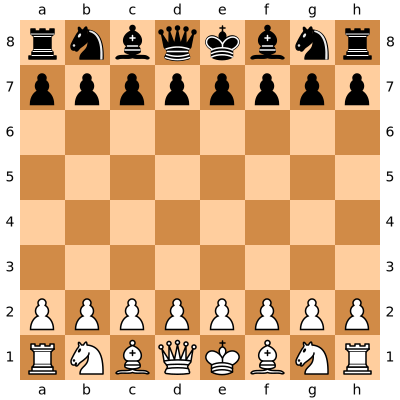

Type your move in UCI format:
f2f3


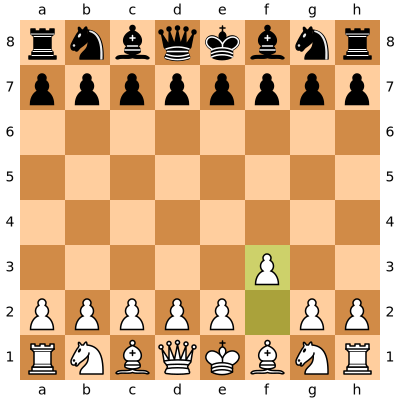

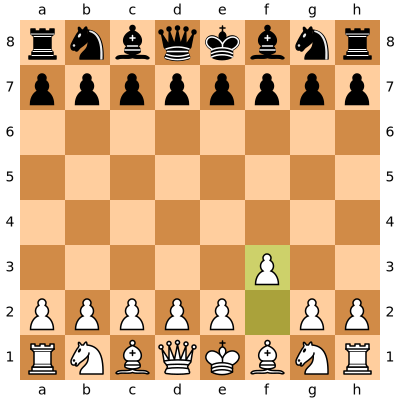

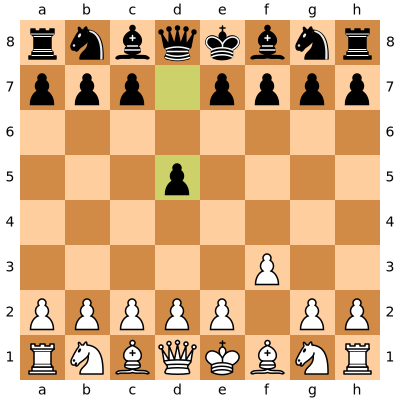

Type your move in UCI format:
g2g4


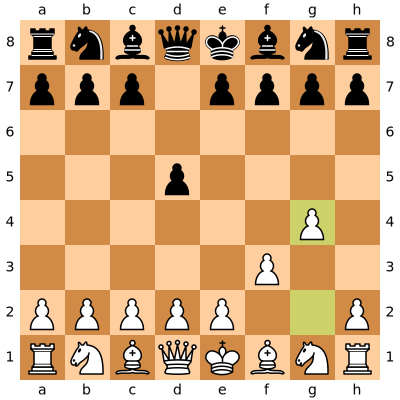

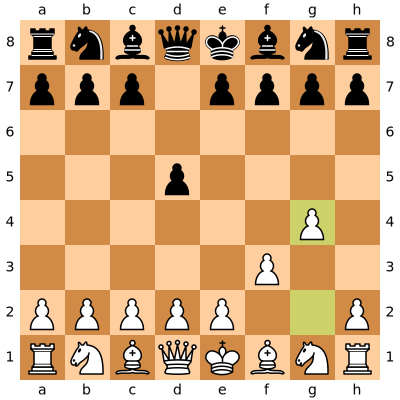

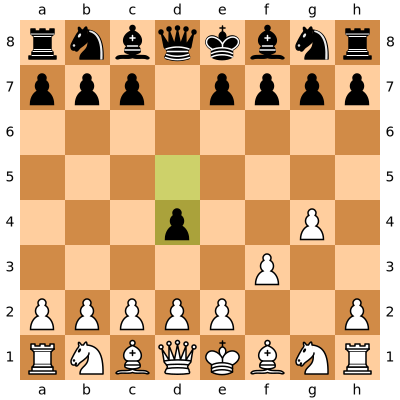

Type your move in UCI format:
a2a4


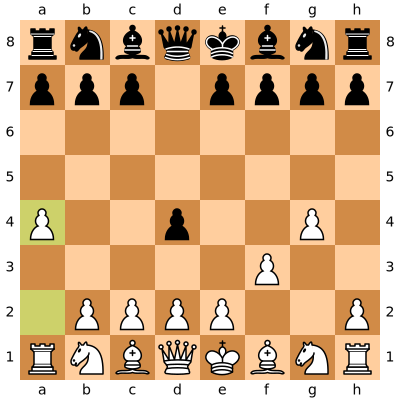

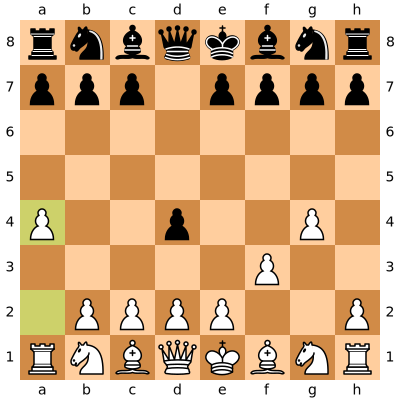

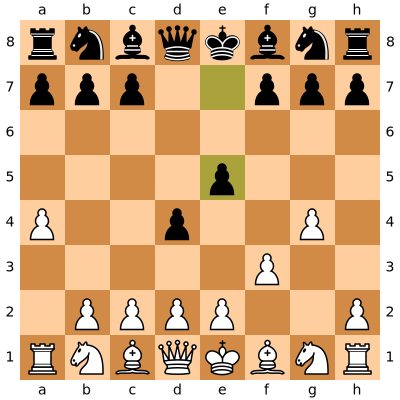

Type your move in UCI format:
a4a5


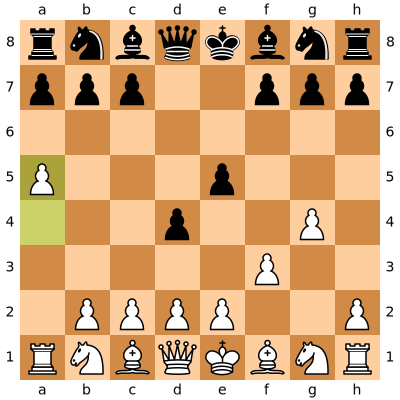

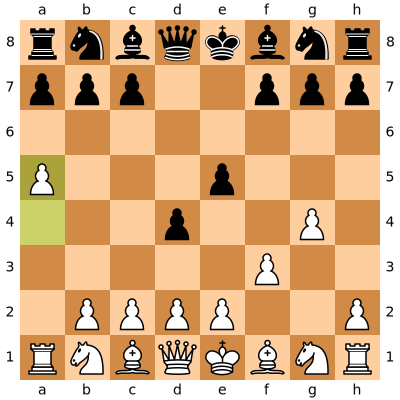

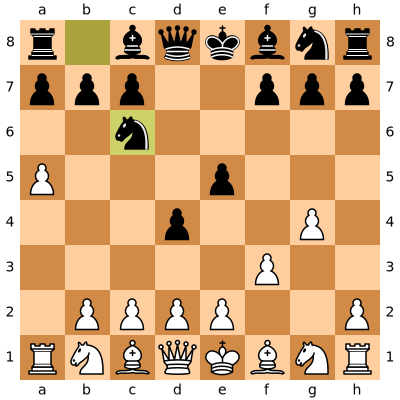

Type your move in UCI format:


In [ ]:
playchess()